### EDA

In [33]:
import pandas as pd
import re

# Load the datasets
true_df = pd.read_csv("News-_dataset/True.csv")
fake_df = pd.read_csv("News-_dataset/Fake.csv")

# Add labels
true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news




In [34]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [35]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [36]:
# Combine
df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)

In [37]:
df.head()

,title,text,subject,date,label
0,Turkey to detain 99 suspects in widening post-...,ISTANBUL (Reuters) - Turkish authorities issue...,worldnews,"November 23, 2017",1
1,"Trump, Abe didn't discuss bilateral FTA: Japan...",TOKYO (Reuters) - U.S. President Donald Trump ...,worldnews,"November 6, 2017",1
2,"Among White House hopefuls, Trump least likely...",NEW YORK (Reuters) - The millions of Twitter u...,politicsNews,"January 31, 2016",1
3,"DEMOCRAT CONGRESSWOMAN, WIFE OF FELON Threaten...",.@SpeakerRyan the women of America are watchin...,politics,"Jan 16, 2017",0
4,Killing TPP would hand China 'keys to the cast...,LIMA (Reuters) - Failure to ratify the U.S.-le...,politicsNews,"July 29, 2016",1


In [38]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=["title", "text"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


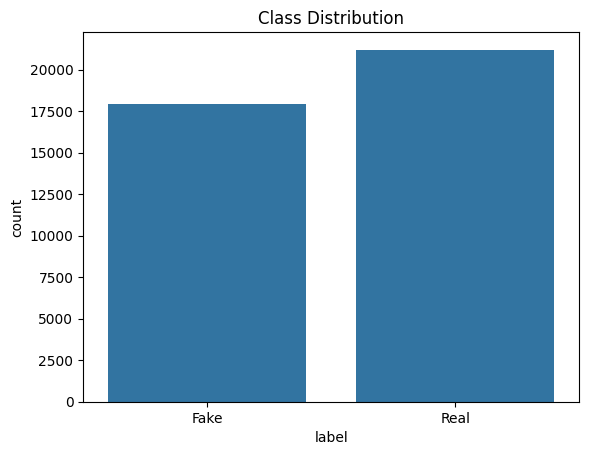

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Class Distribution")
plt.show()


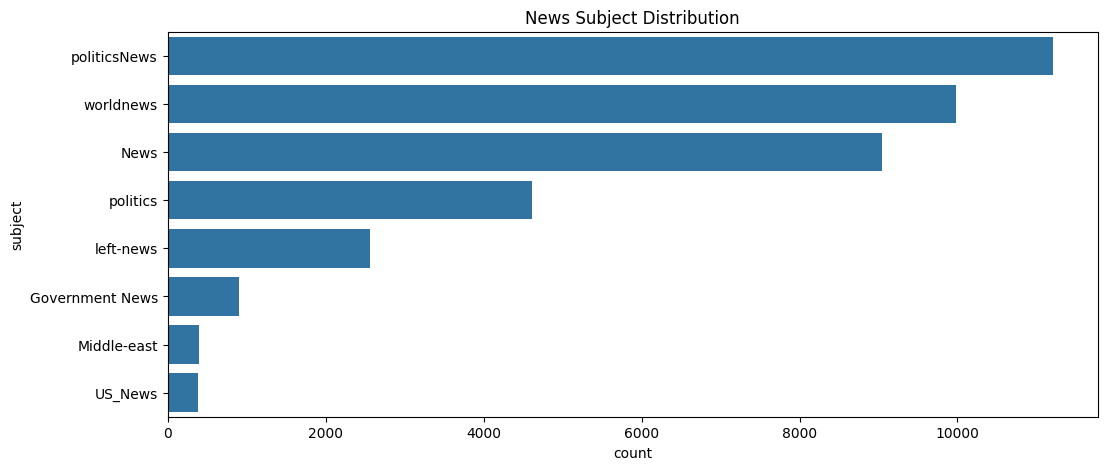

In [41]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.title("News Subject Distribution")
plt.show()


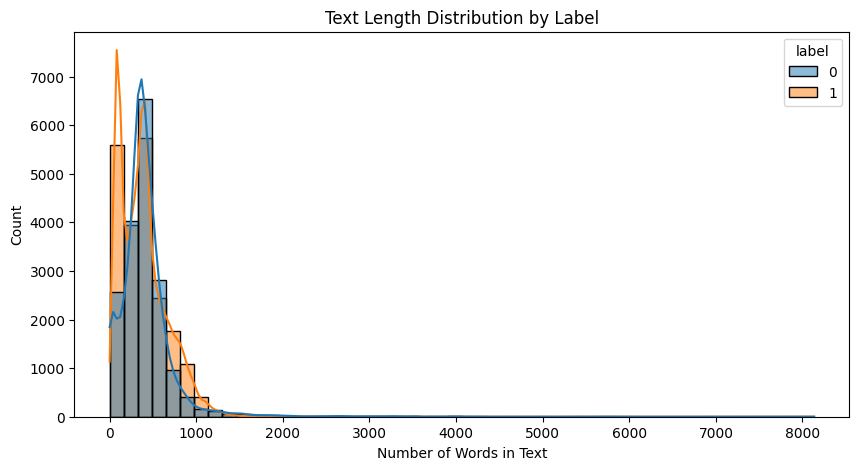

In [42]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Label")
plt.xlabel("Number of Words in Text")
plt.show()


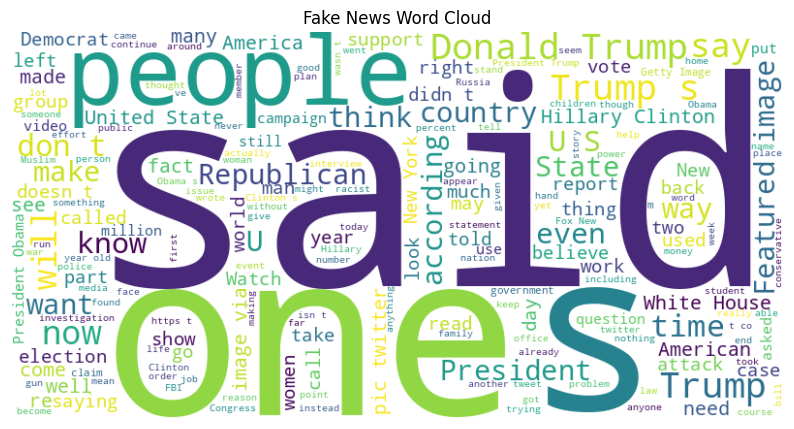

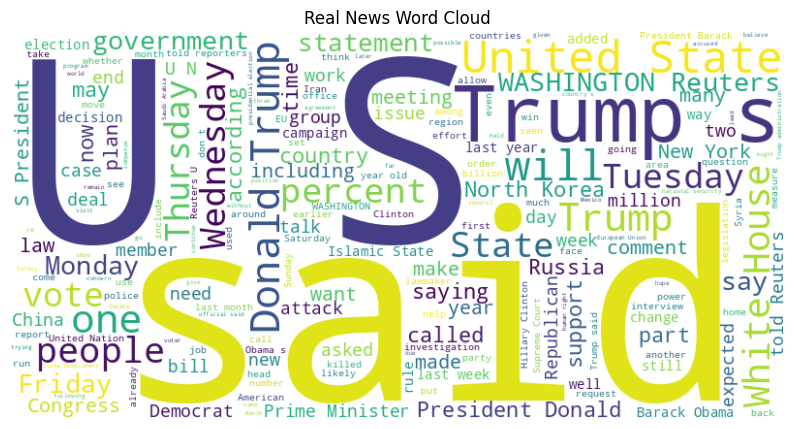

In [43]:
from wordcloud import WordCloud

fake_text = " ".join(fake_df['text'].dropna().values)
real_text = " ".join(true_df['text'].dropna().values)

# Fake News Word Cloud
plt.figure(figsize=(10, 6))
wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")
plt.show()

# Real News Word Cloud
plt.figure(figsize=(10, 6))
wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real News Word Cloud")
plt.show()


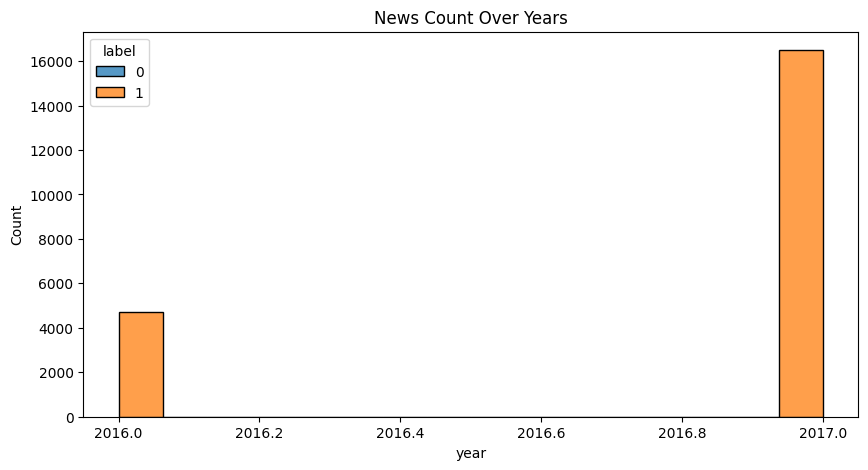

In [44]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='year', hue='label', multiple='stack')
plt.title("News Count Over Years")
plt.show()


In [45]:
# Combine 'title' + 'text' as a single feature
# Combine title and text
df['content'] = df['title'] + " " + df['text']
df.drop(columns=["title", "text", "date"], inplace=True)


# Drop any remaining nulls just in case
df.dropna(subset=["content"], inplace=True)


In [46]:
df.head()

,subject,label,text_length,year,content
0,worldnews,1,239,2017.0,Turkey to detain 99 suspects in widening post-...
1,worldnews,1,78,2017.0,"Trump, Abe didn't discuss bilateral FTA: Japan..."
2,politicsNews,1,773,2016.0,"Among White House hopefuls, Trump least likely..."
3,politics,0,696,NaN,"DEMOCRAT CONGRESSWOMAN, WIFE OF FELON Threaten..."
4,politicsNews,1,400,2016.0,Killing TPP would hand China 'keys to the cast...


In [47]:
df_copy = df.copy(deep=True)

### Removing patterns (boilerplate)

In [48]:
df = df_copy.copy(deep=True)
def clean_text(text):
    # Remove "(Reuters) - " and similar patterns *anywhere* in the text
    text = re.sub(r'\b\w+\s+\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)

    # Identify last sentence using rpartition (better precision)
    text = text.strip()
    last_dot_idx = text.rstrip().rfind('.')  # find last period

    if last_dot_idx != -1:
        before_last, sep, last_sentence = text.rpartition('.')
        if re.search(r'\b(images?|capture|featured|via)\b', last_sentence, re.IGNORECASE):
            text = before_last + '.'  # keep everything before last sentence
        else:
            text = before_last + '.' + last_sentence  # nothing to remove
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove non-letter characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Lowercase and strip extra spaces
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply to the merged title + text content
df['clean_content'] = df['content'].apply(clean_text)



Original [32085]:
e to attack during the next four years. You can download the Apple version of the app here, and the Android version here.Also, remember to follow feeds of progressive organizations on Twitter to keep up with the latest ways to join the resistance against Trump s authoritarian plans. America is counting on all of us to speak truth to power, and to not normalize this unthinkable reality. If we all band together, we just might survive the next four years.Featured image via Drew Angerer/Getty Images

Cleaned  [32085]:
ups that trump and his rag tag team of bigots are sure to attack during the next four years you can download the apple version of the app here and the android version herealso remember to follow feeds of progressive organizations on twitter to keep up with the latest ways to join the resistance against trump s authoritarian plans america is counting on all of us to speak truth to power and to not normalize this unthinkable reality if we all band together we

/tmp/ipykernel_7302/2445493050.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
/tmp/ipykernel_7302/2445493050.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)


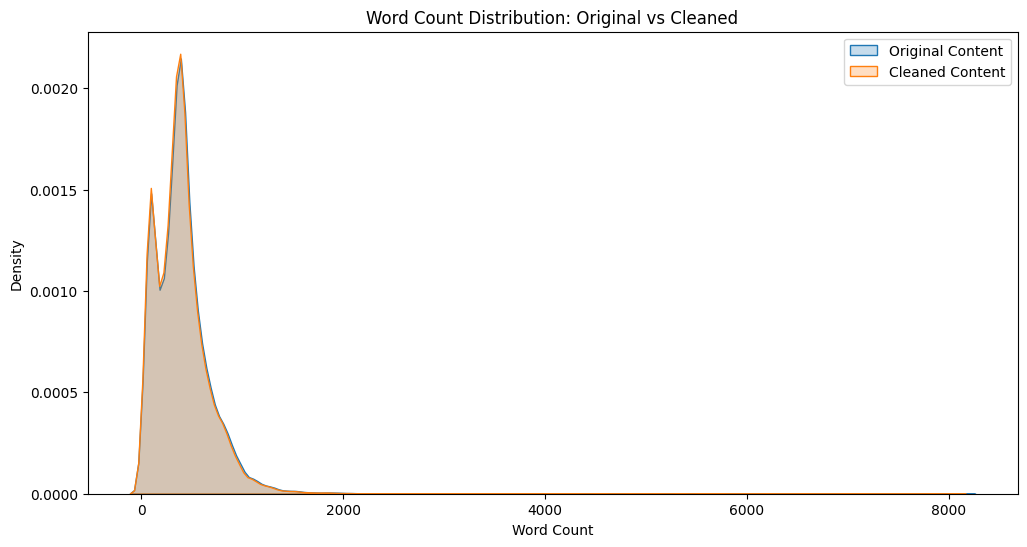

In [49]:
# Show side-by-side comparison of raw vs cleaned content
comparison_df = df[['content', 'clean_content']].sample(50, random_state=42)
for i, row in comparison_df.iterrows():
    # print(f"\nOriginal [{i}]:\n{row['content'][:500]}")
    # print(f"\nCleaned  [{i}]:\n{row['clean_content'][:500]}")
    # print("="*100)
    print(f"\nOriginal [{i}]:\n{row['content'][-500:]}")
    print(f"\nCleaned  [{i}]:\n{row['clean_content'][-500:]}")
    print("="*100)

# Compute length differences
df['raw_len'] = df['content'].apply(lambda x: len(x.split()))
df['clean_len'] = df['clean_content'].apply(lambda x: len(x.split()))
df['reduction'] = df['raw_len'] - df['clean_len']

# Print average reduction
print(f"\nAverage word count reduction: {df['reduction'].mean():.2f} words per article")

# Visualize word count distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)
plt.title("Word Count Distribution: Original vs Cleaned")
plt.xlabel("Word Count")
plt.legend()
plt.show()


In [50]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

Word Count Stats in `clean_content`:
Average: 402.01 words
Maximum: 8057 words
Minimum: 0 words
Median: 370.0 words
Mode: 404


In [51]:
print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (39105, 10)


In [52]:
# Recalculate word count in case it's outdated
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Get indexes where word count is 6 or less
zero_word_indexes = df[df['word_count'] <= 6].index.tolist()

# Display
print(f"Total rows with 6 words or less: {len(zero_word_indexes)}")
print(f"Indexes: {zero_word_indexes}")


Total rows with 6 words or less: 9
Indexes: [3481, 4966, 12975, 17097, 26555, 26783, 27059, 32186, 37719]


In [53]:
# Drop rows where word count is less than or equal to 6
df = df[df['word_count'] > 6].reset_index(drop=True)

print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (39096, 10)


In [54]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

Word Count Stats in `clean_content`:
Average: 402.10 words
Maximum: 8057 words
Minimum: 7 words
Median: 370.0 words
Mode: 404


In [55]:
from collections import Counter

# Compute word counts
word_counts = df['clean_content'].apply(lambda x: len(x.split()))

# Create frequency map
word_count_freq = Counter(word_counts)

# Convert to a sorted dictionary (ascending by word count)
sorted_word_count_freq = dict(sorted(word_count_freq.items()))

# Display the result
print("Word Count Frequency (word_count: num_rows):")
for count, freq in sorted_word_count_freq.items():
    print(f"{count}: {freq}")



Word Count Frequency (word_count: num_rows):
7: 6
8: 10
9: 20
10: 28
11: 47
12: 56
13: 67
14: 64
15: 55
16: 45
17: 51
18: 31
19: 28
20: 21
21: 24
22: 18
23: 26
24: 17
25: 21
26: 24
27: 20
28: 17
29: 26
30: 25
31: 35
32: 31
33: 34
34: 37
35: 35
36: 32
37: 25
38: 29
39: 34
40: 30
41: 31
42: 31
43: 25
44: 31
45: 27
46: 36
47: 37
48: 34
49: 33
50: 30
51: 29
52: 26
53: 32
54: 39
55: 43
56: 43
57: 31
58: 43
59: 34
60: 46
61: 50
62: 46
63: 57
64: 61
65: 47
66: 62
67: 51
68: 71
69: 60
70: 73
71: 90
72: 61
73: 80
74: 87
75: 79
76: 93
77: 87
78: 86
79: 86
80: 87
81: 87
82: 93
83: 92
84: 100
85: 105
86: 81
87: 84
88: 83
89: 88
90: 100
91: 80
92: 77
93: 83
94: 84
95: 88
96: 90
97: 88
98: 76
99: 96
100: 74
101: 70
102: 73
103: 76
104: 75
105: 78
106: 78
107: 59
108: 53
109: 66
110: 56
111: 55
112: 57
113: 70
114: 59
115: 60
116: 54
117: 52
118: 57
119: 56
120: 61
121: 55
122: 56
123: 43
124: 47
125: 60
126: 57
127: 49
128: 52
129: 41
130: 49
131: 53
132: 52
133: 53
134: 43
135: 45
136: 43
137: 45
1

In [56]:
import numpy as np
word_counts = df['clean_content'].apply(lambda x: len(x.split()))
print(f"Max: {word_counts.max()}, 95th percentile: {np.percentile(word_counts, 95)}, Median: {word_counts.median()}")


Max: 8057, 95th percentile: 875.0, Median: 370.0


### Train test val split (70:20:10)

In [57]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df["content"], df["label"],  test_size=0.2, random_state=42,stratify=df["label"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/8, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 27366, Val: 3910, Test: 7820


### Vectorization

In [58]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_val_vec = vectorizer.transform(X_val)

### Training

In [59]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [60]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on validation set
y_val_pred = model.predict(X_val_vec)

# Evaluate
print("Accuracy of validation set:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Accuracy of validation set: 0.9833759590792839
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1790
           1       0.98      0.99      0.98      2120

    accuracy                           0.98      3910
   macro avg       0.98      0.98      0.98      3910
weighted avg       0.98      0.98      0.98      3910



### Evaluation

In [61]:
# Predict
y_pred = model.predict(X_test_vec)
y_probs = model.predict_proba(X_test_vec)[:, 1]  # probabilities for positive class

In [62]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    classification_report,
    roc_auc_score,
    roc_curve
)
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Basic Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

# EER Calculation
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fnr = 1 - tpr
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = interp1d(fpr, fnr)(eer_threshold)

# Display Results
print("Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"EER:       {eer:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))


Evaluation Metrics:
Accuracy:  0.9844
Precision: 0.9800
AUC:       0.9985
EER:       0.0144

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      3580
        Real       0.98      0.99      0.99      4240

    accuracy                           0.98      7820
   macro avg       0.98      0.98      0.98      7820
weighted avg       0.98      0.98      0.98      7820



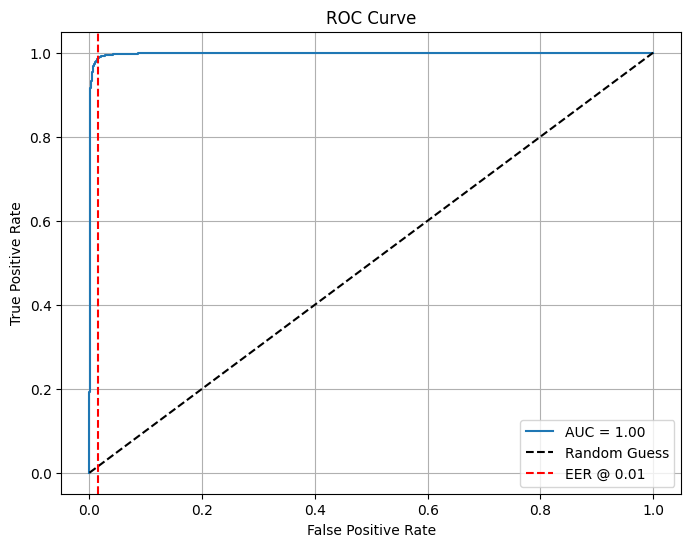

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.axvline(eer_threshold, color='red', linestyle='--', label=f"EER @ {eer_threshold:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


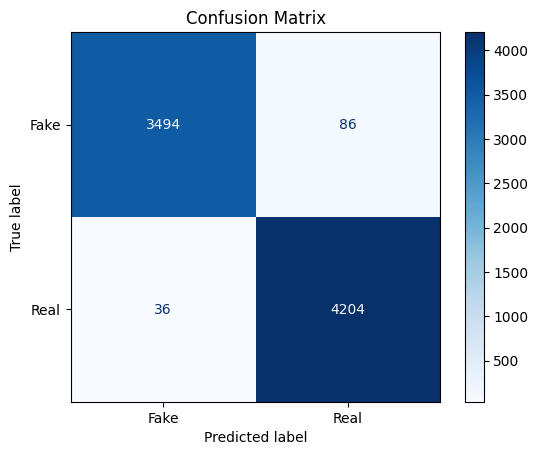

In [64]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
